#### Epoching and averaging(ERP/ERF)
- In MNE, epochs refers to a collection of single trials or short segments of time locked raw data


In [2]:
import os.path as op
import numpy as np
import mne

In [4]:
data_path = mne.datasets.sample.data_path()
fname = op.join(data_path,'MEG','sample','sample_audvis_raw.fif')
raw = mne.io.read_raw_fif(fname,preload=True)
raw.set_eeg_reference() # set EEG average reference

Opening raw data file /home/reallocing/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Current compensation grade : 0
Reading 0 ... 166799  =      0.000 ...   277.714 secs...
Applying average reference.
Applying a custom EEG reference.
Created an SSP operator (subspace dimension = 3)


<Raw  |  sample_audvis_raw.fif, n_channels x n_times : 376 x 166800 (277.7 sec), ~482.3 MB, data loaded>

#### To create time locked epochs, we first need a set of events that contain the information about the times. In this tutorial we use the stimulus channel to define the events. Let’s look at the raw data.

('nchan:', 376)


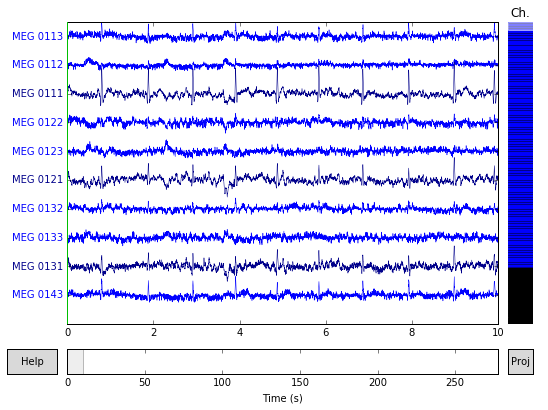

In [15]:
# print(raw.info)
nchan = raw.info['nchan'] #print(len(raw.ch_names)) 通道个数
print("nchan:",nchan)
order = np.arange(nchan)
raw.plot(n_channels=10,order=order,block=True);

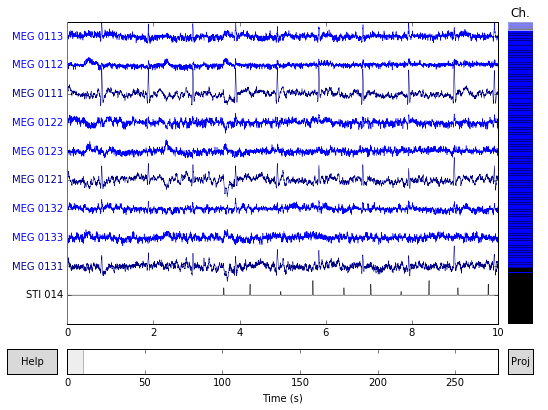

In [17]:
# raw.ch_names[312] 是'STI 014'
order[9] = 312  # We exchange the plotting order of two channels
order[312] = 9  # to show the trigger channel as the 10th channel.
raw.plot(n_channels=10, order=order, block=True);

> The event list contains three columns. 
- The first column corresponds to sample number. To convert this to seconds, you should divide the sample number by the used sampling frequency. 
- The second column is reserved for the old value of the trigger channel at the time of transition, but is currently not in use. 
- The third column is the trigger id (amplitude of the pulse).

In [29]:
events = mne.find_events(raw)
print(events[:10])

320 events found
Event IDs: [ 1  2  3  4  5 32]
[[27977     0     2]
 [28345     0     3]
 [28771     0     1]
 [29219     0     4]
 [29652     0     2]
 [30025     0     3]
 [30450     0     1]
 [30839     0     4]
 [31240     0     2]
 [31665     0     3]]


In [25]:
# Plot the events to get an idea of the paradigm
# Specify colors and an event_id dictionary for the legend.
event_id = {'Auditory/Left': 1, 'Auditory/Right': 2,
            'Visual/Left': 3, 'Visual/Right': 4,
            'smiley': 5, 'button': 32}
color = {1: 'green', 2: 'yellow', 3: 'red', 4: 'c', 5: 'black', 32: 'blue'}

> For instance, the first event has a sample number of 27977 which should translate to roughly 46.6 seconds (27977 / 600). However looking at the pulses we see the first pulse at 3.6 seconds. This is because Neuromag recordings have an attribute **first_samp** which refers to the offset between the system start and the start of the recording. Our data has a first_samp equal to 25800. This means that the first sample you see with raw.plot is the sample number 25800. 

In [30]:
print raw.info['sfreq']
print raw.first_samp

600.614990234
25800


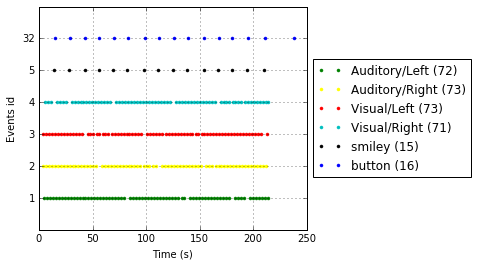

In [26]:
mne.viz.plot_events(events,raw.info['sfreq'],raw.first_samp,color=color,event_id=event_id);

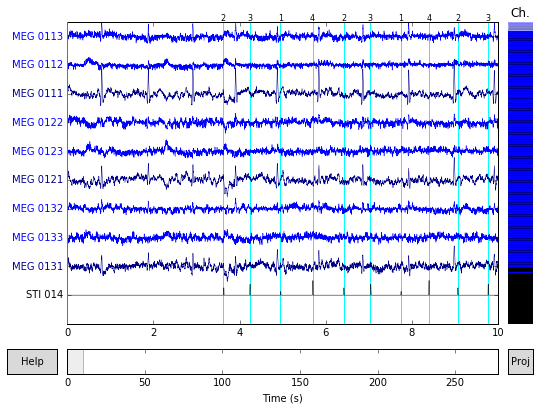

In [32]:
raw.plot(events=events,n_channels=10,order=order);

> In this tutorial we are only interested in triggers 1, 2, 3 and 4. These triggers correspond to auditory and visual stimuli. The event_id here can be an int, a list of ints or a dict. With dicts it is possible to assign these ids to distinct categories. When using ints or lists this information is lost. First we shall define some parameters to feed to the mne.Epochs constructor. The values tmin and tmax refer to offsets in relation to the events. Here we make epochs that collect the data from 200 ms before to 500 ms after the event.

In [33]:
tmin, tmax = -0.2,0.5
event_id = {'Auditory/Left': 1, 'Auditory/Right': 2,
            'Visual/Left': 3, 'Visual/Right': 4}
# Only pick MEG and EOG channels.
picks = mne.pick_types(raw.info, meg=True, eeg=False, eog=True)
print(picks)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [35]:
## To get some meaningful results, we also want to baseline the epochs. Baselining computes the mean over the baseline period and adjusts the data accordingly.
baseline=(None,0.0)
## We also define rejection thresholds to get rid of noisy epochs. 
## The rejection thresholds are defined as peak-to-peak values within the epoch time window. 
## They are defined as T/m for gradiometers, T for magnetometers and V for EEG and EOG electrodes.
reject = {'mag':4e-12,'eog':200e-6}
epochs = mne.Epochs(raw,events=events,event_id=event_id,tmin=tmin,tmax=tmax,reject=reject,picks=picks)

289 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Created an SSP operator (subspace dimension = 3)
3 projection items activated


In [36]:
epochs

<Epochs  |   289 events (good & bad), -0.199795 - 0.499488 sec, baseline [None, 0], ~3.6 MB, data not loaded,
 'Auditory/Left': 72
 'Auditory/Right': 73
 'Visual/Left': 73
 'Visual/Right': 71>

Loading data for 20 events and 421 original time points ...


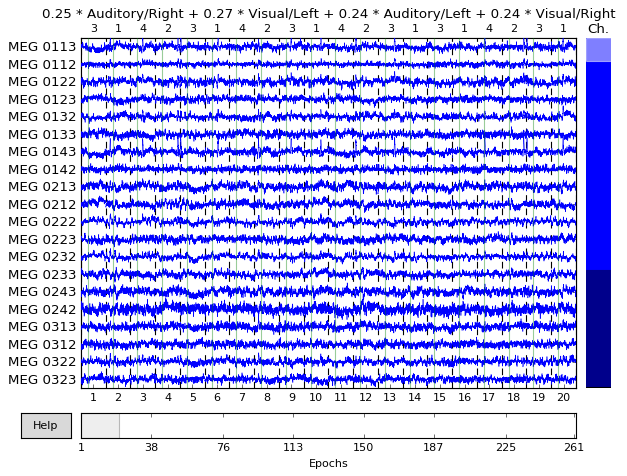

In [47]:
epochs.plot(block=True);

Loading data for 20 events and 421 original time points ...


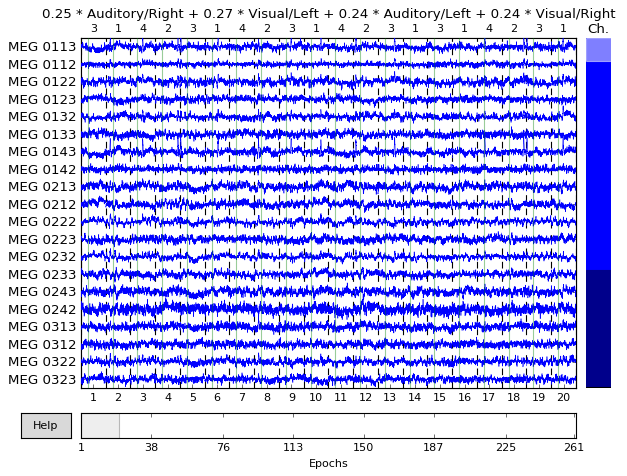

In [48]:
epochs.plot(block=False);

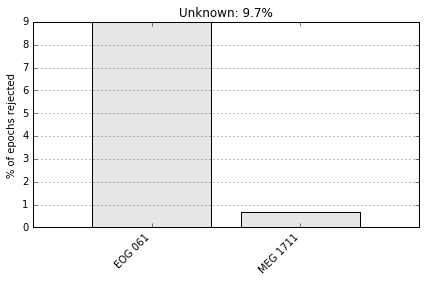

In [39]:
## see why the epochs were rejected, we can plot the drop log.
epochs.plot_drop_log();

In [41]:
picks = mne.pick_types(epochs.info,meg=True,eog=True)
print(picks) ## picks is simply a list of channel indices and as the epochs were constructed, also a new info structure is created where the channel indices run from 0 to epochs.info['nchan']. 
evoked_left = epochs['Auditory/Left'].average(picks=picks)
evoked_right = epochs['Auditory/Right'].average(picks=picks)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [42]:
evoked_left

<Evoked  |  'Auditory/Left' (mean, N=63), [-0.1998, 0.49949] sec, 306 ch, ~4.6 MB>

#### Notice we have used forward slashes (‘/’) to separate the factors of the conditions of the experiment. We can use these ‘tags’ to select for example all left trials (both visual left and auditory right) ...
```python
epochs_left = epochs['Left']

# ... or to select a very specific subset. This is the same as above:
evoked_left = epochs['Left/Auditory'].average(picks=picks)
```

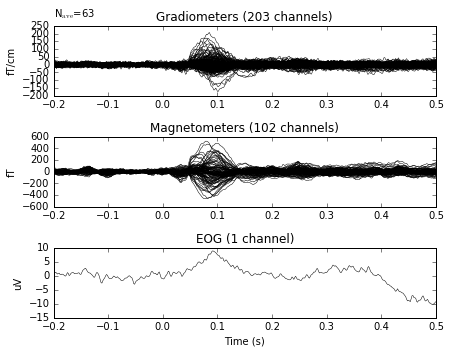

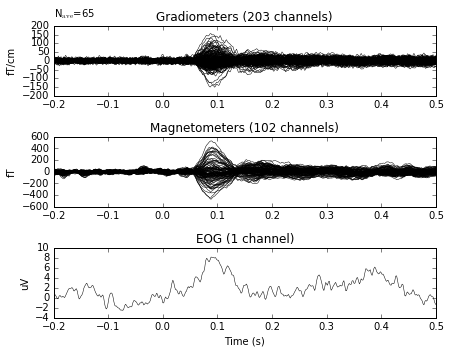

In [43]:
evoked_left.plot();
evoked_right.plot();